In [31]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import numpy as np

import matplotlib.pyplot as plt

from aeon.datasets import load_classification

In [32]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim=16):
        super(Autoencoder, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, latent_dim)
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, input_dim)
        )
    
    def encode(self, x):
        return self.encoder(x)
    
    def forward(self, x):
        latent = self.encoder(x)
        reconstructed = self.decoder(latent)
        return reconstructed

In [33]:
def znorm(x):
  x_znorm = (x - np.mean(x)) / np.std(x)
  return x_znorm

In [34]:
DATASET = 'Rock'

X_train, y_train = load_classification(DATASET, split="train")
X_test, y_test = load_classification(DATASET, split="test")

# Normalização Z-Norm
X_train = np.array([[znorm(series) for series in sample] for sample in X_train])
X_test = np.array([[znorm(series) for series in sample] for sample in X_test])

print(f"Shape treino: {X_train.shape}")
print(f"Shape teste: {X_test.shape}")

Shape treino: (20, 1, 2844)
Shape teste: (50, 1, 2844)


In [35]:
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

X_train_tensor = torch.FloatTensor(X_train_flat)
X_test_tensor = torch.FloatTensor(X_test_flat)

print(f"Tensor: {X_train_tensor.shape}")

Tensor: torch.Size([20, 2844])


In [36]:
train_dataset = TensorDataset(X_train_tensor, X_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [37]:
INPUT_DIM = X_train_flat.shape[1]
REDUCTION_RATE = 0.5
LATENT_DIM = int(INPUT_DIM * REDUCTION_RATE)

model = Autoencoder(INPUT_DIM, LATENT_DIM)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

print(f"\nModelo: {INPUT_DIM} -> {LATENT_DIM} -> {INPUT_DIM}")
# Treinar
EPOCHS = 500

print("Treinando...")
for epoch in range(EPOCHS):
    for data, _ in train_loader:
        output = model(data)
        loss = criterion(output, data)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

print("Treinamento concluído!")


Modelo: 2844 -> 1422 -> 2844
Treinando...
Treinamento concluído!


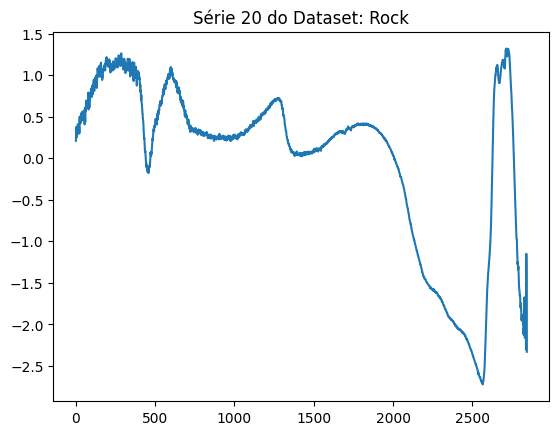

In [38]:
SAMPLE_INDEX = 20
SAMPLE_SERIE = X_test_tensor[SAMPLE_INDEX]

plt.plot(SAMPLE_SERIE)
plt.title(f"Série {SAMPLE_INDEX} do Dataset: {DATASET}")
plt.show()

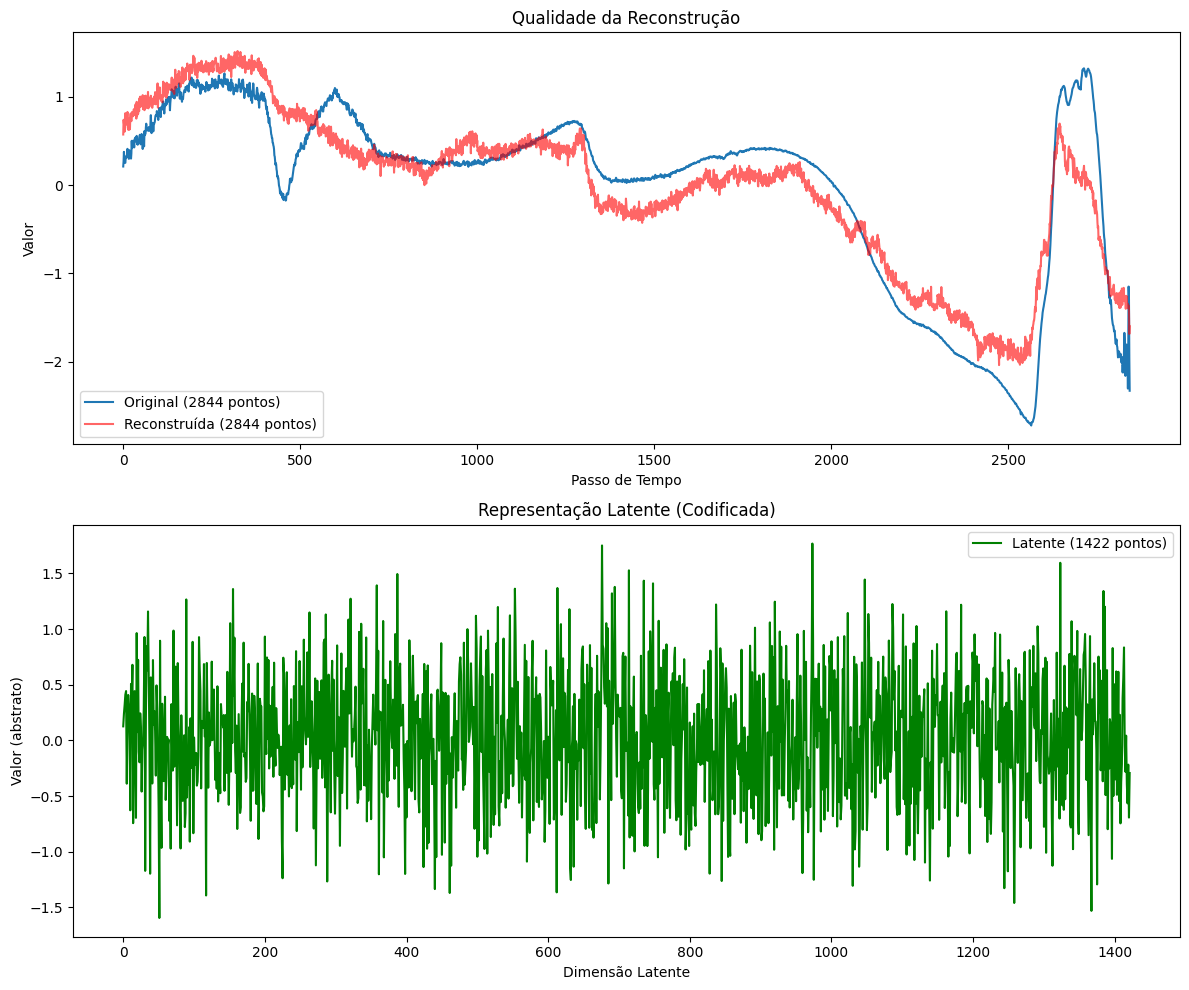

In [46]:
model.eval()
with torch.no_grad():
    # Versão Reconstruída
    reconstructed_data = model(SAMPLE_SERIE) 
    # Versão Latente
    latent_data = model.encode(SAMPLE_SERIE)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# --- Gráfico 1: Original vs. Reconstruída ---
ax1.plot(SAMPLE_SERIE, label=f'Original ({INPUT_DIM} pontos)')
ax1.plot(reconstructed_data, label=f'Reconstruída ({INPUT_DIM} pontos)', color='red', alpha=0.6)
ax1.legend()
ax1.set_title('Qualidade da Reconstrução')
ax1.set_xlabel('Passo de Tempo')
ax1.set_ylabel('Valor')

# --- Gráfico 2: A Representação Latente ---
ax2.plot(latent_data, label=f'Latente ({LATENT_DIM} pontos)', color='green')
ax2.legend()
ax2.set_title('Representação Latente (Codificada)')
ax2.set_xlabel('Dimensão Latente')
ax2.set_ylabel('Valor (abstrato)')

plt.tight_layout()
plt.show()

In [40]:
# (batch, features, seq_len)
X_train_cnn_tensor = torch.FloatTensor(X_train)
X_test_cnn_tensor = torch.FloatTensor(X_test)

train_cnn_dataset = TensorDataset(X_train_cnn_tensor, X_train_cnn_tensor)
train_cnn_loader = DataLoader(train_cnn_dataset, batch_size=32, shuffle=True)

print(f"Shape dos dados de treino para o CNN: {X_train_cnn_tensor.shape}")

Shape dos dados de treino para o CNN: torch.Size([20, 1, 2844])


In [41]:
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()

        self.KERNEL_SIZE = 7
        self.STRIDE = 2
        
        # Encoder
        self.encoder = nn.Sequential(
            # Entrada: [B, C, L] (B=Batch, C=Canais/Features, L=Comprimento)
            nn.Conv1d(in_channels=1, out_channels=8, kernel_size=self.KERNEL_SIZE, stride=self.STRIDE),
            nn.ReLU(),
            nn.Conv1d(8, 16, kernel_size=self.KERNEL_SIZE, stride=self.STRIDE),
            nn.ReLU(),
            nn.Conv1d(16, 32, kernel_size=self.KERNEL_SIZE, stride=self.STRIDE)
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(32, 16, kernel_size=self.KERNEL_SIZE, stride=self.STRIDE),
            nn.ReLU(),
            nn.ConvTranspose1d(16, 8, kernel_size=self.KERNEL_SIZE, stride=self.STRIDE),
            nn.ReLU(),
            nn.ConvTranspose1d(8, 1, kernel_size=self.KERNEL_SIZE, stride=self.STRIDE)
        )

    def encode(self, x):
        return self.encoder(x)
        
    def forward(self, x):
        latent = self.encoder(x)
        reconstructed = self.decoder(latent)
        
        # Ajuste de tamanho para garantir que a saída tenha o mesmo comprimento da entrada
        if reconstructed.shape[-1] > x.shape[-1]:
            reconstructed = reconstructed[..., :x.shape[-1]]
        elif reconstructed.shape[-1] < x.shape[-1]:
            pad = x.shape[-1] - reconstructed.shape[-1]
            reconstructed = nn.functional.pad(reconstructed, (0, pad))
        return reconstructed

In [42]:
model_cae = ConvAutoencoder()
criterion_cae = nn.MSELoss()
optimizer_cae = optim.Adam(model_cae.parameters())

print("Treinando 1D-CNN Autoencoder...")
print(f"Dados de entrada shape: {X_train_cnn_tensor.shape}")

# Loop de Treinamento
num_epochs = 70
train_losses_cnn = []

for epoch in range(num_epochs):
    epoch_loss = 0.0
    for data, _ in train_cnn_loader:
        # --- Forward Pass ---
        output = model_cae(data)
        loss = criterion_cae(output, data)
        
        # --- Backward Pass ---
        optimizer_cae.zero_grad()
        loss.backward()
        optimizer_cae.step()
        
        epoch_loss += loss.item()

    # --- Log ---
    avg_loss = epoch_loss / len(train_cnn_loader)
    train_losses_cnn.append(avg_loss)
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.6f}')

print("Treinamento 1D-CNN concluído!")

Treinando 1D-CNN Autoencoder...
Dados de entrada shape: torch.Size([20, 1, 2844])
Epoch [10/70], Loss: 0.938715
Epoch [20/70], Loss: 0.443229
Epoch [30/70], Loss: 0.204239
Epoch [40/70], Loss: 0.059156
Epoch [50/70], Loss: 0.018938
Epoch [60/70], Loss: 0.017532
Epoch [70/70], Loss: 0.012912
Treinamento 1D-CNN concluído!


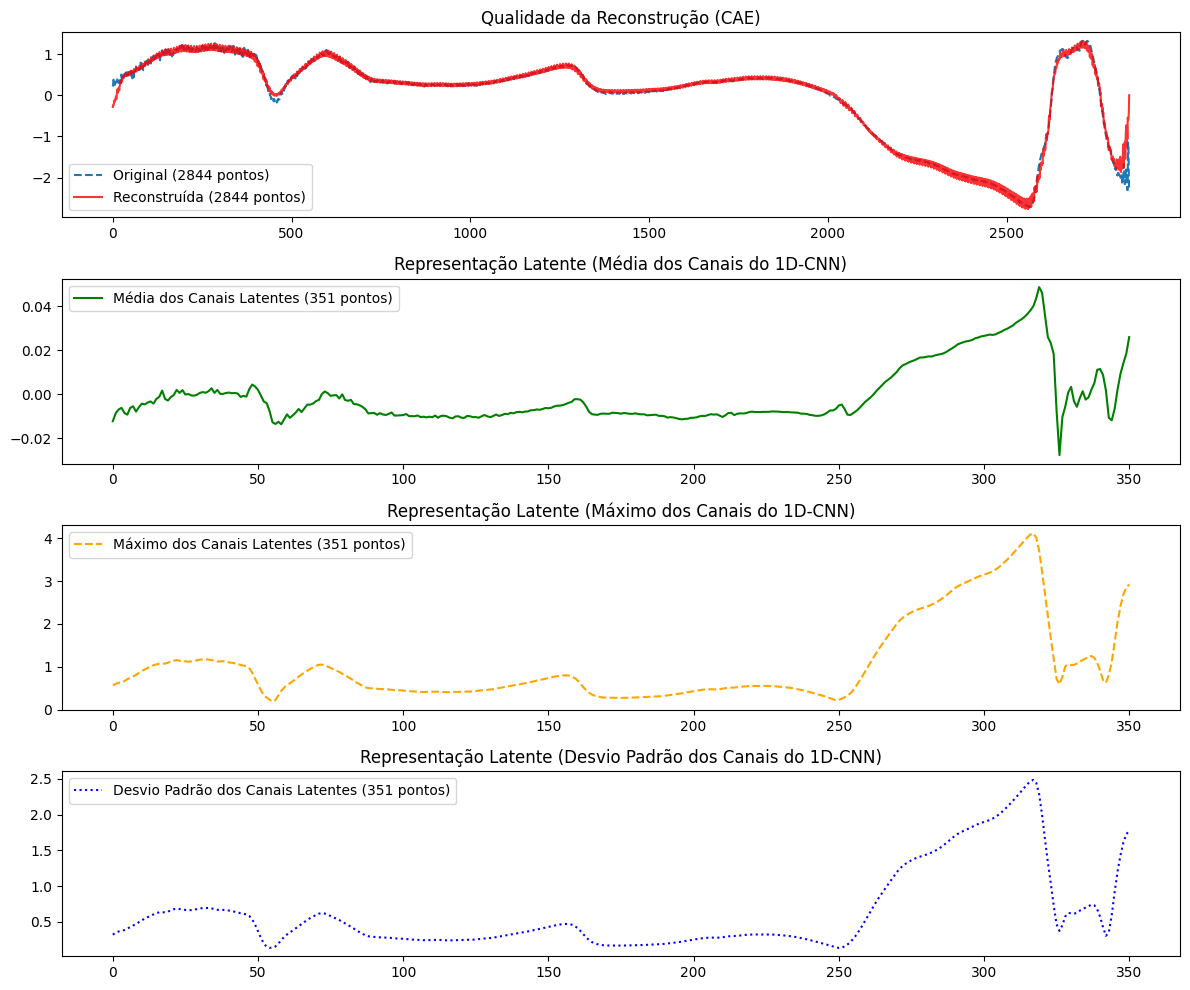

In [52]:
# Coloca o modelo em modo de avaliação
model_cae.eval()
with torch.no_grad():
    # Adiciona dimensões de channel (feature)
    input_cnn = SAMPLE_SERIE.unsqueeze(0).unsqueeze(0) # shape [1, 1, seq_len]
    # Versão Latente (multiplas features)
    latent_data_cnn = model_cae.encode(input_cnn)
    # Versão Reconstruída
    reconstructed_data_cnn = model_cae(input_cnn)

# Remover a dimensão de channel e converte para numpy para plotagem
reconstructed_numpy = reconstructed_data_cnn.squeeze().numpy() # shape [seq_len]
latent_numpy = latent_data_cnn.squeeze().numpy() # shape [n_channels, seq_len]

# ====== Plot ======
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 10))

# --- Gráfico 1: Original vs. Reconstruída (CAE) ---
ax1.plot(SAMPLE_SERIE, label=f'Original ({INPUT_DIM} pontos)', linestyle='--')
ax1.plot(reconstructed_numpy, label=f'Reconstruída ({reconstructed_numpy.shape[0]} pontos)', color='red', alpha=0.8)
ax1.legend()

ax1.set_title('Qualidade da Reconstrução (CAE)')

# --- Gráfico 2: A Representação Latente (CAE) como LINHA ---
# Calcular a média ao longo dos canais (axis=1) para obter uma linha]
latent_mean_line = latent_numpy.mean(axis=0)
# Calcular o máximo
latent_max_line = latent_numpy.max(axis=0)
# Calcular o desvio padrão
latent_std_line = latent_numpy.std(axis=0)

ax2.plot(latent_mean_line, 
         label=f'Média dos Canais Latentes ({latent_mean_line.shape[0]} pontos)', 
         color='green')
ax2.legend()
ax2.set_title('Representação Latente (Média dos Canais do 1D-CNN)')

ax3.plot(latent_max_line, 
         label=f'Máximo dos Canais Latentes ({latent_max_line.shape[0]} pontos)', 
         color='orange', linestyle='--')
ax3.set_title('Representação Latente (Máximo dos Canais do 1D-CNN)')
ax3.legend()

ax4.plot(latent_std_line, 
         label=f'Desvio Padrão dos Canais Latentes ({latent_std_line.shape[0]} pontos)', 
         color='blue', linestyle=':')
ax4.set_title('Representação Latente (Desvio Padrão dos Canais do 1D-CNN)')
ax4.legend()

plt.tight_layout()
plt.show()

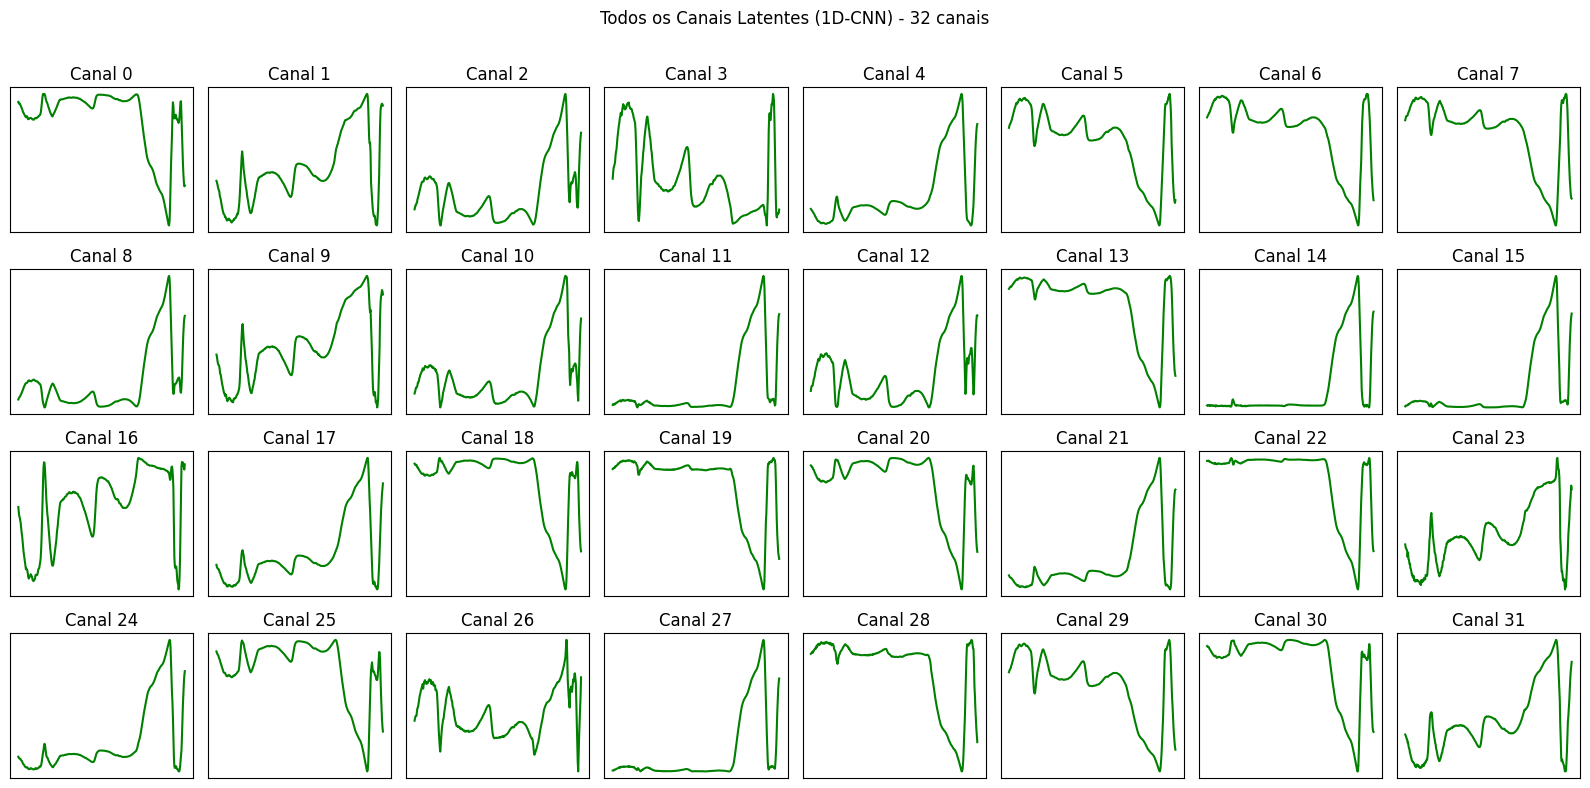

In [44]:
# Ajustado para 32 canais em grade 4x8
N_CHANNELS = latent_data_cnn.shape[1]
rows, cols = 4, 8

fig, axes = plt.subplots(rows, cols, figsize=(16, 8))
for i in range(rows * cols):
  r, c = divmod(i, cols)
  ax = axes[r, c]
  if i < N_CHANNELS:
    ax.plot(latent_numpy[i], color='green')
    ax.set_title(f'Canal {i}')
  else:
    ax.axis('off')  # esconde subplots extras se houver menos de 32 canais
  ax.set_xticks([])
  ax.set_yticks([])

plt.suptitle('Todos os Canais Latentes (1D-CNN) - 32 canais')
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

Canal latente mais próximo (DTW): 7, distância DTW: 120.67


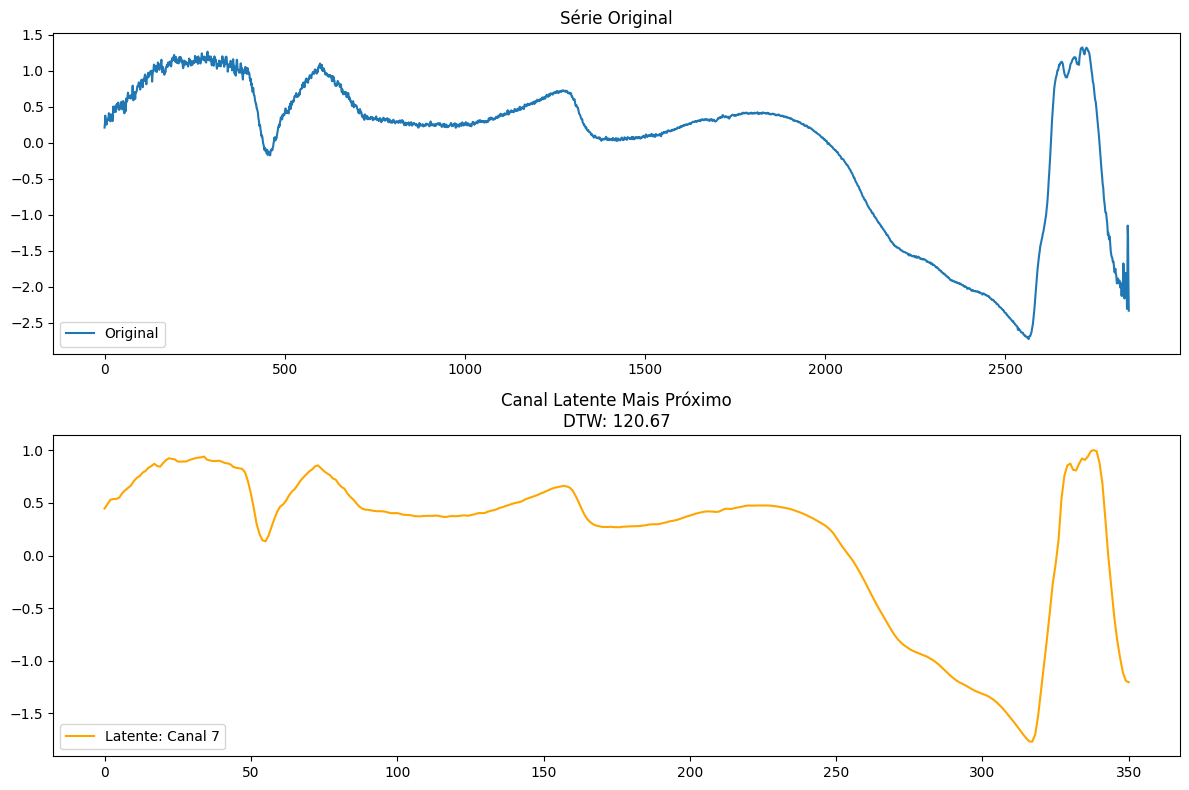

In [45]:
from aeon.distances import dtw_distance

dtw_distances = []
for i in range(latent_numpy.shape[0]):
    dist = dtw_distance(SAMPLE_SERIE.numpy(), latent_numpy[i])
    dtw_distances.append(dist)

best_channel = np.argmin(dtw_distances)
print(f"Canal latente mais próximo (DTW): {best_channel}, distância DTW: {dtw_distances[best_channel]:.2f}")

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

# Série original
ax1.plot(SAMPLE_SERIE, label='Original')
ax1.legend()
ax1.set_title('Série Original')

# Figura 2: Canal latente reduzido
ax2.plot(latent_numpy[best_channel], label=f'Latente: Canal {best_channel}', color='orange')
ax2.legend()
ax2.set_title(f'Canal Latente Mais Próximo\nDTW: {dtw_distances[best_channel]:.2f}')

plt.tight_layout()
plt.show()